In [5]:
dataset_path = "./datasets/tweet_dataset.csv"

In [3]:
import pandas as pd 
import numpy as np
import joblib
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from joblib import dump

In [6]:
df = pd.read_csv(dataset_path,index_col='Unnamed: 0')

In [7]:
df.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


## preprocessing

In [8]:
df['profane'] = df['class'].map(lambda x: True if(x<2) else False)

In [9]:
def preprocessing(x):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())

In [10]:
df['clean_tweets'] = df['tweet'].map(preprocessing)

## model

In [11]:
texts = df["clean_tweets"].astype(str)
y = df["profane"]

vectorizer = TfidfVectorizer(stop_words="english", min_df=0.0001)
X = vectorizer.fit_transform(texts)

In [12]:
model = LinearSVC(class_weight="balanced", dual=False, tol=1e-2, max_iter=1e5)
cclf = CalibratedClassifierCV(base_estimator=model)
cclf.fit(X, y)

CalibratedClassifierCV(base_estimator=LinearSVC(class_weight='balanced',
                                                dual=False, max_iter=100000.0,
                                                tol=0.01))

In [14]:
from sklearn.metrics import classification_report,confusion_matrix

## Training accuracy on twitter dataset

In [15]:
y_pred = cclf.predict(X)
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

       False       0.93      0.98      0.96      4163
        True       1.00      0.99      0.99     20620

    accuracy                           0.99     24783
   macro avg       0.96      0.98      0.97     24783
weighted avg       0.99      0.99      0.99     24783



In [16]:
confusion_matrix(y,y_pred)

array([[ 4094,    69],
       [  297, 20323]])

In [78]:
dump(vectorizer, "./vectorizer.joblib")
dump(cclf, "./model.joblib")

['./model.joblib']

## testing on other dataset

In [17]:
dataset_path= './datasets/wiki_ai_dataset.csv'

In [18]:
df = pd.read_csv(dataset_path)

In [5]:
model = joblib.load('./training/model.joblib')
vectorizer = joblib.load('./training/vectorizer.joblib')

In [6]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [19]:
df['profane'] = df['toxic']+df['severe_toxic']+df['obscene']+df['threat']+df['insult']+df['identity_hate']
df['profane'] = df['profane'].map(lambda x: 1 if(x>0) else 0)

In [20]:
def preprocessing(x):
    x = x.replace("\n"," ")
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())

In [21]:
df['comment_text'] = df['comment_text'].map(preprocessing)

/home/shaury/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='profane', ylabel='count'>

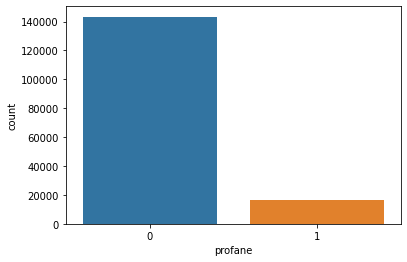

In [10]:
import seaborn as sns
sns.countplot(df['profane'])

## taking sample from major class as we have to test on whether its profane or not

## sample ratio : {0:30000 , 1:20000}

In [22]:
Dataf = pd.concat([df[df['profane']==False].sample(n = 30000),df[df['profane']==True]],axis=0).reset_index(drop = True)

In [23]:
X = vectorizer.transform(Dataf['comment_text'])

In [25]:
y_pred = cclf.predict(X)

In [26]:
print(classification_report(Dataf['profane'],y_pred))

              precision    recall  f1-score   support

           0       0.86      0.57      0.68     30000
           1       0.51      0.83      0.63     16225

    accuracy                           0.66     46225
   macro avg       0.68      0.70      0.66     46225
weighted avg       0.74      0.66      0.66     46225



In [27]:
confusion_matrix(Dataf['profane'],y_pred)

array([[16980, 13020],
       [ 2742, 13483]])

# testing on the values of this , the data is unbalanced 